In [1]:
# Import packages

import pandas as pd 
import numpy as np 
import os
from bs4 import BeautifulSoup
import time
import requests
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import random
import scipy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import pickle
from joblib import dump, load

import warnings

# Set certain settings for the notebook
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

C:\Users\imacd_0odruq3\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
betting_df = pd.read_excel('https://www.aussportsbetting.com/historical_data/nfl.xlsx')

In [3]:
betting_data = betting_df.copy()
betting_data = betting_data[['Date', 'Home Team', 'Away Team', 'Home Score', 'Away Score', 'Home Odds Close', 'Away Odds Close', 
             'Home Line Close', 'Away Line Close', 'Total Score Close']]

In [4]:
def decimal_to_moneyline(decimal):
    if np.isnan(decimal):
        return np.nan
    elif decimal >= 2.00:
        return np.round((decimal-1) * 100)
    else: 
        return np.round(-100 / (decimal-1))
    
def get_over_under_result(game, lineopen=True):
    game_score = game['Total Score']
    if lineopen:
        ou_score = game['Total Score Open']
    else:
        ou_score = game['Total Score Close']
        
    if game_score == ou_score :
        result = 'Push'
    elif game_score > ou_score:
        result = 'Over'
    else:
        result = 'Under'
        
    return result 

def fix_home_team_names(game):
    team_mapping = {
        'Oakland Raiders':'Las Vegas Raiders',
        'St. Louis Rams':'Los Angeles Rams',
        'San Diego Chargers':'Los Angeles Chargers',
        'Washington Redskins':'Washington Football Team',
        'Washington Commanders':'Washington Football Team'
    }
    
    if game['Home Team'] in team_mapping.keys():
        return team_mapping[game['Home Team']]
    
    else:
        return game['Home Team']
    
def fix_away_team_names(game):
    team_mapping = {
        'Oakland Raiders':'Las Vegas Raiders',
        'St. Louis Rams':'Los Angeles Rams',
        'San Diego Chargers':'Los Angeles Chargers',
        'Washington Redskins':'Washington Football Team',
        'Washington Commanders':'Washington Football Team'
    }
    
    if game['Away Team'] in team_mapping.keys():
        return team_mapping[game['Away Team']]
    
    else:
        return game['Away Team']


betting_data['Home Team'] = betting_data.apply(lambda x: fix_home_team_names(x), axis=1)
betting_data['Away Team'] = betting_data.apply(lambda x: fix_away_team_names(x), axis=1)
    
betting_data['Home Odds ML Close'] = betting_data['Home Odds Close'].apply(lambda x: decimal_to_moneyline(x))
betting_data['Away Odds ML Close'] = betting_data['Away Odds Close'].apply(lambda x: decimal_to_moneyline(x))

betting_data = betting_data[betting_data.Date >= '2022-03-01']
betting_data['Total Score'] = betting_data.apply(lambda x: x['Home Score'] + x['Away Score'], axis=1)

betting_data['Over/Under Result'] = betting_data.apply(lambda x: get_over_under_result(x, lineopen=False), axis=1)

betting_data['Home Score Actual Line'] = betting_data.apply(lambda x: x['Away Score'] - x['Home Score'], axis=1)
betting_data['Away Score Actual Line'] = betting_data.apply(lambda x: x['Home Score'] - x['Away Score'], axis=1)

betting_data

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds Close,Away Odds Close,Home Line Close,Away Line Close,Total Score Close,Home Odds ML Close,Away Odds ML Close,Total Score,Over/Under Result,Home Score Actual Line,Away Score Actual Line
0,2022-10-31,Cleveland Browns,Cincinnati Bengals,32,13,2.50,1.58,3.0,-3.0,45.0,150.0,-172.0,45,Push,-19,19
1,2022-10-30,Buffalo Bills,Green Bay Packers,27,17,1.19,5.00,-10.5,10.5,47.0,-526.0,400.0,44,Under,-10,10
2,2022-10-30,Indianapolis Colts,Washington Football Team,16,17,1.66,2.30,-3.0,3.0,40.0,-152.0,130.0,33,Under,1,-1
3,2022-10-30,Los Angeles Rams,San Francisco 49ers,14,31,1.86,1.95,-1.0,1.0,42.0,-116.0,-105.0,45,Over,17,-17
4,2022-10-30,Seattle Seahawks,New York Giants,27,13,1.58,2.50,-3.0,3.0,44.5,-172.0,150.0,40,Under,-14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-09-11,Houston Texans,Indianapolis Colts,20,20,3.75,1.28,7.0,-7.0,45.5,275.0,-357.0,40,Under,0,0
119,2022-09-11,Miami Dolphins,New England Patriots,20,7,1.58,2.50,-3.0,3.0,46.5,-172.0,150.0,27,Under,-13,13
120,2022-09-11,New York Jets,Baltimore Ravens,9,24,3.40,1.33,6.5,-6.5,44.0,240.0,-303.0,33,Under,15,-15
121,2022-09-11,Washington Football Team,Jacksonville Jaguars,28,22,1.64,2.35,-3.0,3.0,43.0,-156.0,135.0,50,Over,-6,6


In [5]:
predictive_stats = pd.read_csv('../data/predictive_stats_df.csv')
predictive_stats = predictive_stats[(predictive_stats.season == 2022)]
predictive_stats

,Unnamed: 0,season,week,home,away,home_full_name,away_full_name,season_home,week_home,team_full_name_home,qb_home,total_pass_attempts_last_6_avg_home,total_passing_yards_last_6_avg_home,completions_last_6_avg_home,passing_epa_last_6_avg_home,pass_tds_last_6_avg_home,avg_cpoe_last_6_avg_home,qb_epa_last_6_avg_home,sacks_allowed_last_6_avg_home,interceptions_thrown_last_6_avg_home,qb_value_pre_last_6_avg_home,qb_adj_last_6_avg_home,total_rushes_last_6_avg_home,total_rush_yards_last_6_avg_home,rushing_epa_last_6_avg_home,rush_tds_last_6_avg_home,fumbles_last_6_avg_home,lost_fumbles_last_6_avg_home,ypc_last_6_avg_home,total_rushes_allowed_last_6_avg_home,total_rush_yards_allowed_last_6_avg_home,rush_tds_allowed_last_6_avg_home,total_pass_attempts_allowed_last_6_avg_home,passing_yards_allowed_last_6_avg_home,completions_allowed_last_6_avg_home,pass_tds_allowed_last_6_avg_home,avg_cpoe_allowed_last_6_avg_home,sacks_last_6_avg_home,fumbles_forced_last_6_avg_home,interceptions_last_6_avg_home,fumbles_recovered_last_6_avg_home,special_teams_epa_last_6_avg_home,passing_epa_def_last_6_avg_home,rushing_epa_def_last_6_avg_home,season_away,week_away,team_full_name_away,qb_away,total_pass_attempts_last_6_avg_away,total_passing_yards_last_6_avg_away,completions_last_6_avg_away,passing_epa_last_6_avg_away,pass_tds_last_6_avg_away,avg_cpoe_last_6_avg_away,qb_epa_last_6_avg_away,sacks_allowed_last_6_avg_away,interceptions_thrown_last_6_avg_away,qb_value_pre_last_6_avg_away,qb_adj_last_6_avg_away,total_rushes_last_6_avg_away,total_rush_yards_last_6_avg_away,rushing_epa_last_6_avg_away,rush_tds_last_6_avg_away,fumbles_last_6_avg_away,lost_fumbles_last_6_avg_away,ypc_last_6_avg_away,total_rushes_allowed_last_6_avg_away,total_rush_yards_allowed_last_6_avg_away,rush_tds_allowed_last_6_avg_away,total_pass_attempts_allowed_last_6_avg_away,passing_yards_allowed_last_6_avg_away,completions_allowed_last_6_avg_away,pass_tds_allowed_last_6_avg_away,avg_cpoe_allowed_last_6_avg_away,sacks_last_6_avg_away,fumbles_forced_last_6_avg_away,interceptions_last_6_avg_away,fumbles_recovered_last_6_avg_away,special_teams_epa_last_6_avg_away,passing_epa_def_last_6_avg_away,rushing_epa_def_last_6_avg_away
239,285,2022,1,LAR,BUF,Los Angeles Rams,Buffalo Bills,2022,1,Los Angeles Rams,Matthew Stafford,35.000000,295.833333,24.333333,10.260848,2.333333,5.549945,10.448003,2.166667,1.166667,185.952558,2.185934,27.000000,78.500000,-9.442989,0.500000,0.833333,0.833333,2.884288,22.166667,90.333333,0.666667,35.500000,250.666667,22.000000,1.166667,-6.185407,3.333333,0.500000,1.166667,0.333333,0.297185,5.598976,0.571105,2022,1,Buffalo Bills,Josh Allen,36.333333,256.500000,22.166667,10.121293,2.833333,0.503211,16.121521,1.166667,0.666667,250.918899,6.162398,28.666667,155.000000,7.002993,1.666667,0.500000,0.000000,5.349456,23.833333,119.166667,1.166667,32.500000,199.500000,18.166667,1.166667,-9.020295,4.000000,0.666667,0.833333,0.166667,-0.566416,3.621674,-1.726747
240,287,2022,1,WSH,JAX,Washington Football Team,Jacksonville Jaguars,2022,1,Washington Football Team,Carson Wentz,27.166667,180.166667,16.500000,-2.936697,1.500000,-5.768720,-0.781519,2.333333,0.666667,140.516197,0.235844,25.166667,114.166667,0.722648,0.833333,1.333333,0.500000,4.380327,29.166667,127.333333,1.000000,33.833333,245.500000,22.000000,1.333333,0.073661,2.666667,0.166667,0.833333,0.166667,-0.761191,-1.225379,0.549484,2022,1,Jacksonville Jaguars,Trevor Lawrence,33.833333,212.000000,21.333333,-4.020721,0.500000,-2.988697,-3.613128,2.000000,1.166667,75.915923,-18.523269,22.333333,82.333333,-3.847259,0.500000,0.833333,0.500000,3.411034,29.000000,142.833333,1.333333,30.833333,212.333333,20.166667,1.666667,-0.477098,2.166667,0.333333,0.333333,0.166667,-3.052658,-4.653238,-1.915483
241,288,2022,1,MIA,NE,Miami Dolphins,New England Patriots,2022,1,Miami Dolphins,Tua Tagovailoa,31.000000,197.000000,20.833333,-1.081374,1.166667,0.909200,-0.487964,2.166667,0.666667,148.866795,12.362190,31.500000,120.500000,-3.205870,0.833333,

In [6]:
# Load moneyline predictor algorithm 

ml_algo = load('../saved_models/xgboost_iter_1_depth_4_estimators_125.joblib')

In [7]:
# Load point spread predictor algorithm 

hs_algo = load('../saved_models/elasticnet_hs_iter_1_alpha_0.25_ratio_1.joblib')
as_algo = load('../saved_models/elasticnet_as_iter_1_alpha_1_ratio_0.1.joblib')

In [8]:
# Load over under predictor algorithm 

ou_algo = load('../saved_models/elasticnet_ts_iter_1_alpha_1_ratio_0.joblib')

In [9]:
# Function for getting predictions

def get_predictions(trained_model, testing_set, target = 'game_winner', predict_home = 'True'):
    
    test = testing_set.copy()
    test.drop(columns = ['season', 'week', 'home', 'away', 'home_full_name', 'away_full_name',
                         'season_home', 'week_home', 'season_away', 'week_away', 
                         'team_full_name_home', 'team_full_name_away', 'qb_home', 'qb_away', 'Unnamed: 0'], 
                          inplace=True)
    preds = testing_set.copy()
    preds = preds[['season', 'week', 'home_full_name', 'away_full_name']]
        
    if target == 'game_winner':
    
        pred = trained_model.predict(test)
        
        pred_prob = trained_model.predict_proba(test)
        
        preds['home_win_pred'] = pred
        preds[['away_win_prob', 'home_win_prob']] = pred_prob
        
        return preds
        
    elif target == 'point_spread':
        pred = trained_model.predict(test)
        
        if predict_home:
            preds['home_score_pred'] = pred
            
        else:
            preds['away_score_pred'] = pred
        
        return preds
    
    else:
        pred = trained_model.predict(test)
        
        preds['total_score_pred'] = pred
        
        return preds

In [10]:
# Get predictions

ml_preds = get_predictions(ml_algo, predictive_stats, target='game_winner')
hs_preds = get_predictions(hs_algo, predictive_stats, target='point_spread')
as_preds = get_predictions(as_algo, predictive_stats, target='point_spread', predict_home = False)
ts_preds = get_predictions(ou_algo, predictive_stats, target='total_score')

combined_predictions = ml_preds.merge(hs_preds).merge(as_preds).merge(ts_preds)
combined_predictions = combined_predictions[['season', 'week', 'home_full_name', 'away_full_name', 
                                            'home_win_pred', 'home_win_prob', 'away_win_prob', 
                                            'home_score_pred', 'away_score_pred', 'total_score_pred']]
combined_predictions

,season,week,home_full_name,away_full_name,home_win_pred,home_win_prob,away_win_prob,home_score_pred,away_score_pred,total_score_pred
0,2022,1,Los Angeles Rams,Buffalo Bills,0,0.324052,0.675948,20.429601,25.279852,45.223804
1,2022,1,Washington Football Team,Jacksonville Jaguars,1,0.788429,0.211571,25.648667,17.686919,43.230369
2,2022,1,Miami Dolphins,New England Patriots,1,0.611502,0.388498,22.097193,17.036484,38.745552
3,2022,1,Chicago Bears,San Francisco 49ers,1,0.507643,0.492357,20.692645,20.684892,41.176389
4,2022,1,Carolina Panthers,Cleveland Browns,1,0.589871,0.410129,19.727278,22.227076,42.325054
...,...,...,...,...,...,...,...,...,...,...
122,2022,9,Atlanta Falcons,Los Angeles Chargers,1,0.501552,0.498448,22.877514,24.402410,47.526010
123,2022,9,Arizona Cardinals,Seattle Seahawks,0,0.300659,0.699341,22.580008,23.392264,46.385529
124,2022,9,Tampa Bay Buccaneers,Los Angeles Rams,0,0.436811,0.563189,25.311334,22.669942,47.345184
125,2022,9,Kansas City Chiefs,Tennessee Titans,1,0.778514,0.221486,27.271399,15.956592,43.198094


In [11]:
print(len(betting_data))
print(len(combined_predictions))

123
127


In [12]:
combined_results = betting_data.merge(combined_predictions, 
                             left_on = ['Home Team', 'Away Team'], 
                             right_on = ['home_full_name', 'away_full_name'])
combined_results

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds Close,Away Odds Close,Home Line Close,Away Line Close,Total Score Close,Home Odds ML Close,Away Odds ML Close,Total Score,Over/Under Result,Home Score Actual Line,Away Score Actual Line,season,week,home_full_name,away_full_name,home_win_pred,home_win_prob,away_win_prob,home_score_pred,away_score_pred,total_score_pred
0,2022-10-31,Cleveland Browns,Cincinnati Bengals,32,13,2.50,1.58,3.0,-3.0,45.0,150.0,-172.0,45,Push,-19,19,2022,8,Cleveland Browns,Cincinnati Bengals,1,0.563729,0.436271,23.857301,24.405656,48.763983
1,2022-10-30,Buffalo Bills,Green Bay Packers,27,17,1.19,5.00,-10.5,10.5,47.0,-526.0,400.0,44,Under,-10,10,2022,8,Buffalo Bills,Green Bay Packers,1,0.754181,0.245819,28.231131,20.415413,48.392964
2,2022-10-30,Los Angeles Rams,San Francisco 49ers,14,31,1.86,1.95,-1.0,1.0,42.0,-116.0,-105.0,45,Over,17,-17,2022,8,Los Angeles Rams,San Francisco 49ers,1,0.688858,0.311142,23.177008,21.547750,45.036538
3,2022-10-30,Seattle Seahawks,New York Giants,27,13,1.58,2.50,-3.0,3.0,44.5,-172.0,150.0,40,Under,-14,14,2022,8,Seattle Seahawks,New York Giants,0,0.446190,0.553810,22.520292,22.316113,44.299128
4,2022-10-30,Atlanta Falcons,Carolina Panthers,37,34,1.50,2.70,-4.0,4.0,41.0,-200.0,170.0,71,Over,-3,3,2022,8,Atlanta Falcons,Carolina Panthers,1,0.718531,0.281469,25.270501,17.992504,43.847321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2022-09-11,Houston Texans,Indianapolis Colts,20,20,3.75,1.28,7.0,-7.0,45.5,275.0,-357.0,40,Under,0,0,2022,1,Houston Texans,Indianapolis Colts,0,0.363027,0.636973,20.456048,24.657620,45.424629
110,2022-09-11,Miami Dolphins,New England Patriots,20,7,1.58,2.50,-3.0,3.0,46.5,-172.0,150.0,27,Under,-13,13,2022,1,Miami Dolphins,New England Patriots,1,0.611502,0.388498,22.097193,17.036484,38.745552
111,2022-09-11,New York Jets,Baltimore Ravens,9,24,3.40,1.33,6.5,-6.5,44.0,240.0,-303.0,33,Under,15,-15,2022,1,New York Jets,Baltimore Ravens,1,0.609480,0.390520,21.957418,26.217485,48.306203
112,2022-09-11,Washington Football Team,Jacksonville Jaguars,28,22,1.64,2.35,-3.0,3.0,43.0,-156.0,135.0,50,Over,-6,6,2022,1,Washington Football Team,Jacksonville Jaguars,1,0.788429,0.211571,25.648667,17.686919,43.230369


In [13]:
len(combined_results)

114

In [14]:
def get_implied_probability(game, open_line=True, home=True):
    
    if home:
        home_or_away = 'Home'
    else:
        home_or_away = 'Away'
        
    betting_column = '{} Odds ML Close'.format(home_or_away)
    
    ml_odds = game[betting_column]
    
    if ml_odds > 0:
        return (100/(ml_odds + 100))
    else:
        return (-ml_odds/(-ml_odds + 100))

combined_results['implied_prob_home'] = combined_results.apply(lambda x: get_implied_probability(x, home=True), axis=1)
combined_results['implied_prob_away'] = combined_results.apply(lambda x: get_implied_probability(x, home=False), axis=1)
combined_results

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds Close,Away Odds Close,Home Line Close,Away Line Close,Total Score Close,Home Odds ML Close,Away Odds ML Close,Total Score,Over/Under Result,Home Score Actual Line,Away Score Actual Line,season,week,home_full_name,away_full_name,home_win_pred,home_win_prob,away_win_prob,home_score_pred,away_score_pred,total_score_pred,implied_prob_home,implied_prob_away
0,2022-10-31,Cleveland Browns,Cincinnati Bengals,32,13,2.50,1.58,3.0,-3.0,45.0,150.0,-172.0,45,Push,-19,19,2022,8,Cleveland Browns,Cincinnati Bengals,1,0.563729,0.436271,23.857301,24.405656,48.763983,0.400000,0.632353
1,2022-10-30,Buffalo Bills,Green Bay Packers,27,17,1.19,5.00,-10.5,10.5,47.0,-526.0,400.0,44,Under,-10,10,2022,8,Buffalo Bills,Green Bay Packers,1,0.754181,0.245819,28.231131,20.415413,48.392964,0.840256,0.200000
2,2022-10-30,Los Angeles Rams,San Francisco 49ers,14,31,1.86,1.95,-1.0,1.0,42.0,-116.0,-105.0,45,Over,17,-17,2022,8,Los Angeles Rams,San Francisco 49ers,1,0.688858,0.311142,23.177008,21.547750,45.036538,0.537037,0.512195
3,2022-10-30,Seattle Seahawks,New York Giants,27,13,1.58,2.50,-3.0,3.0,44.5,-172.0,150.0,40,Under,-14,14,2022,8,Seattle Seahawks,New York Giants,0,0.446190,0.553810,22.520292,22.316113,44.299128,0.632353,0.400000
4,2022-10-30,Atlanta Falcons,Carolina Panthers,37,34,1.50,2.70,-4.0,4.0,41.0,-200.0,170.0,71,Over,-3,3,2022,8,Atlanta Falcons,Carolina Panthers,1,0.718531,0.281469,25.270501,17.992504,43.847321,0.666667,0.370370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2022-09-11,Houston Texans,Indianapolis Colts,20,20,3.75,1.28,7.0,-7.0,45.5,275.0,-357.0,40,Under,0,0,2022,1,Houston Texans,Indianapolis Colts,0,0.363027,0.636973,20.456048,24.657620,45.424629,0.266667,0.781182
110,2022-09-11,Miami Dolphins,New England Patriots,20,7,1.58,2.50,-3.0,3.0,46.5,-172.0,150.0,27,Under,-13,13,2022,1,Miami Dolphins,New England Patriots,1,0.611502,0.388498,22.097193,17.036484,38.745552,0.632353,0.400000
111,2022-09-11,New York Jets,Baltimore Ravens,9,24,3.40,1.33,6.5,-6.5,44.0,240.0,-303.0,33,Under,15,-15,2022,1,New York Jets,Baltimore Ravens,1,0.609480,0.390520,21.957418,26.217485,48.306203,0.294118,0.751861
112,2022-09-11,Washington Football Team,Jacksonville Jaguars,28,22,1.64,2.35,-3.0,3.0,43.0,-156.0,135.0,50,Over,-6,6,2022,1,Washington Football Team,Jacksonville Jaguars,1,0.788429,0.211571,25.648667,17.686919,43.230369,0.609375,0.425532


In [15]:
def calculate_return(game, bet_type = 'moneyline', home_bet=True, wager=100, over=True):
    
    if home_bet:
        line = game['Home Odds ML Close']
    else:
        line = game['Away Odds ML Close']
        
    if bet_type == 'moneyline':
        if (home_bet and game['Home Score'] > game['Away Score']) or (not home_bet and game['Home Score'] < game['Away Score']):
            if line > 0:
                return np.round(((line/100)*wager), 2)
            else:
                return np.round(((100/abs(line))*wager), 2)
        elif game['Home Score'] == game['Away Score']:
            return 0
        else:
            return np.round(-wager, 2)
        
    elif bet_type == 'spread':
        if (home_bet and game['Home Line Close'] > game['Home Score Actual Line']) or (not home_bet and game['Away Line Close'] > game['Away Score Actual Line']):
            return np.round(((100/110)*wager), 2)
        elif game['Home Line Close'] == game['Home Score Actual Line']:
            return 0
        else:
            return np.round(-wager, 2)
            
    elif bet_type == 'over_under':
        if (game['Over/Under Result'] == 'Over' and over) or (game['Over/Under Result'] == 'Under' and not over):
            return np.round(((100/110)*wager), 2)
        elif game['Over/Under Result'] == 'Push':
            return 0 
        else:
            return np.round(-wager, 2)
    
combined_results['home_ml_bet_return'] = combined_results.apply(lambda x: calculate_return(x, bet_type='moneyline', 
                                                                                          home_bet=True, wager=100,
                                                                                          over=True), axis=1)
combined_results['away_ml_bet_return'] = combined_results.apply(lambda x: calculate_return(x, bet_type='moneyline', 
                                                                                          home_bet=False, wager=100,
                                                                                          over=True), axis=1)
combined_results['home_spread_bet_return'] = combined_results.apply(lambda x: calculate_return(x, bet_type='spread', 
                                                                                          home_bet=True, wager=100,
                                                                                          over=True), axis=1)
combined_results['away_spread_bet_return'] = combined_results.apply(lambda x: calculate_return(x, bet_type='spread', 
                                                                                          home_bet=False, wager=100,
                                                                                          over=True), axis=1)
combined_results['over_bet_return'] = combined_results.apply(lambda x: calculate_return(x, bet_type='over_under', 
                                                                                          home_bet=True, wager=100,
                                                                                          over=True), axis=1)
combined_results['under_bet_return'] = combined_results.apply(lambda x: calculate_return(x, bet_type='over_under', 
                                                                                          home_bet=True, wager=100,
                                                                                          over=False), axis=1)
combined_results

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds Close,Away Odds Close,Home Line Close,Away Line Close,Total Score Close,Home Odds ML Close,Away Odds ML Close,Total Score,Over/Under Result,Home Score Actual Line,Away Score Actual Line,season,week,home_full_name,away_full_name,home_win_pred,home_win_prob,away_win_prob,home_score_pred,away_score_pred,total_score_pred,implied_prob_home,implied_prob_away,home_ml_bet_return,away_ml_bet_return,home_spread_bet_return,away_spread_bet_return,over_bet_return,under_bet_return
0,2022-10-31,Cleveland Browns,Cincinnati Bengals,32,13,2.50,1.58,3.0,-3.0,45.0,150.0,-172.0,45,Push,-19,19,2022,8,Cleveland Browns,Cincinnati Bengals,1,0.563729,0.436271,23.857301,24.405656,48.763983,0.400000,0.632353,150.00,-100.00,90.91,-100.00,0.00,0.00
1,2022-10-30,Buffalo Bills,Green Bay Packers,27,17,1.19,5.00,-10.5,10.5,47.0,-526.0,400.0,44,Under,-10,10,2022,8,Buffalo Bills,Green Bay Packers,1,0.754181,0.245819,28.231131,20.415413,48.392964,0.840256,0.200000,19.01,-100.00,-100.00,90.91,-100.00,90.91
2,2022-10-30,Los Angeles Rams,San Francisco 49ers,14,31,1.86,1.95,-1.0,1.0,42.0,-116.0,-105.0,45,Over,17,-17,2022,8,Los Angeles Rams,San Francisco 49ers,1,0.688858,0.311142,23.177008,21.547750,45.036538,0.537037,0.512195,-100.00,95.24,-100.00,90.91,90.91,-100.00
3,2022-10-30,Seattle Seahawks,New York Giants,27,13,1.58,2.50,-3.0,3.0,44.5,-172.0,150.0,40,Under,-14,14,2022,8,Seattle Seahawks,New York Giants,0,0.446190,0.553810,22.520292,22.316113,44.299128,0.632353,0.400000,58.14,-100.00,90.91,-100.00,-100.00,90.91
4,2022-10-30,Atlanta Falcons,Carolina Panthers,37,34,1.50,2.70,-4.0,4.0,41.0,-200.0,170.0,71,Over,-3,3,2022,8,Atlanta Falcons,Carolina Panthers,1,0.718531,0.281469,25.270501,17.992504,43.847321,0.666667,0.370370,50.00,-100.00,-100.00,90.91,90.91,-100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2022-09-11,Houston Texans,Indianapolis Colts,20,20,3.75,1.28,7.0,-7.0,45.5,275.0,-357.0,40,Under,0,0,2022,1,Houston Texans,Indianapolis Colts,0,0.363027,0.636973,20.456048,24.657620,45.424629,0.266667,0.781182,0.00,0.00,90.91,-100.00,-100.00,90.91
110,2022-09-11,Miami Dolphins,New England Patriots,20,7,1.58,2.50,-3.0,3.0,46.5,-172.0,150.0,27,Under,-13,13,2022,1,Miami Dolphins,New England Patriots,1,0.611502,0.388498,22.097193,17.036484,38.745552,0.632353,0.400000,58.14,-100.00,90.91,-100.00,-100.00,90.91
111,2022-09-11,New York Jets,Baltimore Ravens,9,24,3.40,1.33,6.5,-6.5,44.0,240.0,-303.0,33,Under,15,-15,2022,1,New York Jets,Baltimore Ravens,1,0.609480,0.390520,21.957418,26.217485,48.306203,0.294118,0.751861,-100.00,33.00,-100.00,90.91,-100.00,90.91
112,2022-09-11,Washington Football Team,Jacksonville Jaguars,28,22,1.64,2.35,-3.0,3.0,43.0,-156.0,135.0,50,Over,-6,6,2022,1,Washington Football Team,Jacksonville Jaguars,1,0.788429,0.211571,25.648667,17.686919,43.230369,0.609375,0.425532,64.10,-100.00,90.91,-100.00,90.91,-100.00


In [16]:
def get_prob_advantage_algo(game):
    advantage_home = game['home_win_prob'] - game['implied_prob_home']
    advantage_away = game['away_win_prob'] - game['implied_prob_away']
    
    if advantage_home > advantage_away:
        return advantage_home, 'home'
    else:
        return advantage_away, 'away'
    
def get_bet_proportional_algo(game):
    
    bet_weight = 0
    
    if game.best_prob_advantage >= .2 :
        bet_weight = 1
        
    return bet_weight
    
combined_results = combined_results.join(pd.DataFrame(combined_results.apply(lambda x: get_prob_advantage_algo(x), axis=1).tolist(), columns=['best_prob_advantage', 'advantage_team']))
combined_results['moneyline_bet_proportion'] = combined_results.apply(lambda x: get_bet_proportional_algo(x), axis=1)

In [17]:
# Get spread differences 

combined_results['home_spread_pred'] = combined_results.apply(lambda x: x.away_score_pred - x.home_score_pred, axis=1)
combined_results['away_spread_pred'] = combined_results.apply(lambda x: x.home_score_pred - x.away_score_pred, axis=1)
combined_results['home_line_diff'] = combined_results.apply(lambda x: x['Home Line Close'] - x.home_spread_pred, axis=1)
combined_results['away_line_diff'] = combined_results.apply(lambda x: x['Away Line Close'] - x.away_spread_pred, axis=1)
combined_results['total_score_diff'] = combined_results.apply(lambda x: x.total_score_pred - x['Total Score Close'], axis=1)

In [18]:
def get_best_spread_advantage(game):
    
    if game.home_line_diff > game.away_line_diff:
        return game.home_line_diff, 'home'
    else:
        return game.away_line_diff, 'away'
    
def get_best_ou_advantage(game):
    
    if game.total_score_diff > 0:
        return 'over'
    else:
        return 'under'
    
def get_return_proportional_spread(game):
    
    bet_weight = 0
    
    if game.best_spread_advantage >= 5 :
        bet_weight = 1
        
    return bet_weight
    
def get_return_proportional_ou(game):
    
    bet_weight = 0
    
    if abs(game.total_score_diff) >= 3 :
        bet_weight = 1
        
    return bet_weight

def get_team_to_bet_on(game):
    
    if game.spread_bet_proportion <= 0:
        return game.advantage_team
    else:
        return game.spread_advantage_team

combined_results[['best_spread_advantage', 'spread_advantage_team']] = combined_results.apply(lambda x: get_best_spread_advantage(x), axis=1, result_type='expand')
combined_results['spread_bet_proportion'] = combined_results.apply(lambda x: get_return_proportional_spread(x), axis=1)
combined_results['ou_advantage'] = combined_results.apply(lambda x: get_best_ou_advantage(x), axis=1)
combined_results['ou_bet_proportion'] = combined_results.apply(lambda x: get_return_proportional_ou(x), axis=1)
combined_results

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds Close,Away Odds Close,Home Line Close,Away Line Close,Total Score Close,Home Odds ML Close,Away Odds ML Close,Total Score,Over/Under Result,Home Score Actual Line,Away Score Actual Line,season,week,home_full_name,away_full_name,home_win_pred,home_win_prob,away_win_prob,home_score_pred,away_score_pred,total_score_pred,implied_prob_home,implied_prob_away,home_ml_bet_return,away_ml_bet_return,home_spread_bet_return,away_spread_bet_return,over_bet_return,under_bet_return,best_prob_advantage,advantage_team,moneyline_bet_proportion,home_spread_pred,away_spread_pred,home_line_diff,away_line_diff,total_score_diff,best_spread_advantage,spread_advantage_team,spread_bet_proportion,ou_advantage,ou_bet_proportion
0,2022-10-31,Cleveland Browns,Cincinnati Bengals,32,13,2.50,1.58,3.0,-3.0,45.0,150.0,-172.0,45,Push,-19,19,2022,8,Cleveland Browns,Cincinnati Bengals,1,0.563729,0.436271,23.857301,24.405656,48.763983,0.400000,0.632353,150.00,-100.00,90.91,-100.00,0.00,0.00,0.163729,home,0,0.548355,-0.548355,2.451645,-2.451645,3.763983,2.451645,home,0,over,1
1,2022-10-30,Buffalo Bills,Green Bay Packers,27,17,1.19,5.00,-10.5,10.5,47.0,-526.0,400.0,44,Under,-10,10,2022,8,Buffalo Bills,Green Bay Packers,1,0.754181,0.245819,28.231131,20.415413,48.392964,0.840256,0.200000,19.01,-100.00,-100.00,90.91,-100.00,90.91,0.045819,away,0,-7.815718,7.815718,-2.684282,2.684282,1.392964,2.684282,away,0,over,0
2,2022-10-30,Los Angeles Rams,San Francisco 49ers,14,31,1.86,1.95,-1.0,1.0,42.0,-116.0,-105.0,45,Over,17,-17,2022,8,Los Angeles Rams,San Francisco 49ers,1,0.688858,0.311142,23.177008,21.547750,45.036538,0.537037,0.512195,-100.00,95.24,-100.00,90.91,90.91,-100.00,0.151821,home,0,-1.629257,1.629257,0.629257,-0.629257,3.036538,0.629257,home,0,over,1
3,2022-10-30,Seattle Seahawks,New York Giants,27,13,1.58,2.50,-3.0,3.0,44.5,-172.0,150.0,40,Under,-14,14,2022,8,Seattle Seahawks,New York Giants,0,0.446190,0.553810,22.520292,22.316113,44.299128,0.632353,0.400000,58.14,-100.00,90.91,-100.00,-100.00,90.91,0.153810,away,0,-0.204179,0.204179,-2.795821,2.795821,-0.200872,2.795821,away,0,under,0
4,2022-10-30,Atlanta Falcons,Carolina Panthers,37,34,1.50,2.70,-4.0,4.0,41.0,-200.0,170.0,71,Over,-3,3,2022,8,Atlanta Falcons,Carolina Panthers,1,0.718531,0.281469,25.270501,17.992504,43.847321,0.666667,0.370370,50.00,-100.00,-100.00,90.91,90.91,-100.00,0.051864,home,0,-7.277997,7.277997,3.277997,-3.277997,2.847321,3.277997,home,0,over,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2022-09-11,Houston Texans,Indianapolis Colts,20,20,3.75,1.28,7.0,-7.0,45.5,275.0,-357.0,40,Under,0,0,2022,1,Houston Texans,Indianapolis Colts,0,0.363027,0.636973,20.456048,24.657620,45.424629,0.266667,0.781182,0.00,0.00,90.91,-100.00,-100.00,90.91,0.096361,home,0,4.201572,-4.201572,2.798428,-2.798428,-0.075371,2.798428,home,0,under,0
110,2022-09-11,Miami Dolphins,New England Patriots,20,7,1.58,2.50,-3.0,3.0,46.5,-172.0,150.0,27,Under,-13,13,2022,1,Miami Dolphins,New England Patriots,1,0.611502,0.388498,22.097193,17.036484,38.745552,0.632353,0.400000,58.14,-100.00,90.91,-100.00,-100.00,90.91,-0.011502,away,0,-5.060710,5.060710,2.060710,-2.060710,-7.754448,2.060710,home,0,under,1
111,2022-09-11,New York Jets,Baltimore Ravens,9,24,3.40,1.33,6.5,-6.5,44.0,240.0,-303.0,33,Under,15,-15,2022,1,New York Jets,Baltimore Ravens,1,0.609480,0.390520,21.957418,26.217485,48.306203,0.294118,0.751861,-100.00,33.00,-100.00,90.91,-100.00,90.91,0.315362,home,1,4.260066,-4.260066,2.239934,-2.239934,4.306203,2.239934,home,0,over,1
112,2022-09-11,Washington Football Team,Jacksonville Jaguars,28,22,1.64,2.35,-3.0,3.0,43.0,-156.0,135.0,50,Over,-6,6,2022,1,Washington Football Team,Jacksonville Jaguars,1,0.788429,0.211571,25.648667,17.686919,43.230369,0.609375,0.425532,64.10,-100.00,90.91,-100.00,90.91,-100.00,0.179054,home,0

In [21]:
# def get_ml_weighted_avg(game):
    
#     if game.advantage_team_algo == 'home':
#         return game.best_prob_advantage_algo * (game.home_win_prob * 2)
#     else:
#         return game.best_prob_advantage_algo * (game.away_win_prob * 2)

def get_return_proportional_ml(game):
    
    bet_weight = 0
    
    # Only use first one, game.best_prob_advantage_algo
    
    if game.best_prob_advantage >= .2:
        bet_weight = 1

#     elif game.ml_weighted_avg >= .2:
#         bet_weight = 1
        
    if game.advantage_team == 'home':
        return bet_weight * game['home_ml_bet_return'], bet_weight * 100
    else:
        return bet_weight * game['away_ml_bet_return'], bet_weight * 100
    
def get_return_proportional_ou(game):
    
    bet_weight = 0
    
    if abs(game.total_score_diff) >= 3 :
        bet_weight = 1
        
    return bet_weight * game['{}_bet_return'.format(game.ou_advantage)], bet_weight*100


def get_return_proportional_spread(game):
    
    bet_weight = 0
    
    if game.best_spread_advantage > 5:
        bet_weight = 1

#     if game.spread_advantage_team_algo == 'Home':
#         if game.implied_prob_home_open > .5:
#             bet_weight = 1
#     else:
#         if game.implied_prob_home_open < .5:
#             bet_weight = 1
            
    if game.spread_advantage_team == 'home':
        return bet_weight * game['home_spread_bet_return'], bet_weight * 100
    else:
        return bet_weight * game['away_spread_bet_return'], bet_weight * 100
    
gambling_df = combined_results.copy()
# gambling_df['ml_weighted_avg'] = gambling_df.apply(lambda x: get_ml_weighted_avg(x), axis=1)
gambling_df[['moneyline_returns', 'moneyline_wagered']] = gambling_df.apply(lambda x: get_return_proportional_ml(x), axis=1, result_type='expand')
gambling_df[['spread_returns', 'spread_wagered']] = gambling_df.apply(lambda x: get_return_proportional_spread(x), axis=1, result_type='expand')
gambling_df[['ou_returns', 'ou_wagered']] = gambling_df.apply(lambda x: get_return_proportional_ou(x), axis=1, result_type='expand')
gambling_df['total_returns'] = gambling_df.moneyline_returns + gambling_df.spread_returns + gambling_df.ou_returns
gambling_df['total_wagered'] = gambling_df.moneyline_wagered + gambling_df.spread_wagered + gambling_df.ou_wagered

gambling_df

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds Close,Away Odds Close,Home Line Close,Away Line Close,Total Score Close,Home Odds ML Close,Away Odds ML Close,Total Score,Over/Under Result,Home Score Actual Line,Away Score Actual Line,season,week,home_full_name,away_full_name,home_win_pred,home_win_prob,away_win_prob,home_score_pred,away_score_pred,total_score_pred,implied_prob_home,implied_prob_away,home_ml_bet_return,away_ml_bet_return,home_spread_bet_return,away_spread_bet_return,over_bet_return,under_bet_return,best_prob_advantage,advantage_team,moneyline_bet_proportion,home_spread_pred,away_spread_pred,home_line_diff,away_line_diff,total_score_diff,best_spread_advantage,spread_advantage_team,spread_bet_proportion,ou_advantage,ou_bet_proportion,moneyline_returns,moneyline_wagered,spread_returns,spread_wagered,ou_returns,ou_wagered,total_returns,total_wagered
0,2022-10-31,Cleveland Browns,Cincinnati Bengals,32,13,2.50,1.58,3.0,-3.0,45.0,150.0,-172.0,45,Push,-19,19,2022,8,Cleveland Browns,Cincinnati Bengals,1,0.563729,0.436271,23.857301,24.405656,48.763983,0.400000,0.632353,150.00,-100.00,90.91,-100.00,0.00,0.00,0.163729,home,0,0.548355,-0.548355,2.451645,-2.451645,3.763983,2.451645,home,0,over,1,0.0,0.0,0.0,0.0,0.00,100.0,0.00,100.0
1,2022-10-30,Buffalo Bills,Green Bay Packers,27,17,1.19,5.00,-10.5,10.5,47.0,-526.0,400.0,44,Under,-10,10,2022,8,Buffalo Bills,Green Bay Packers,1,0.754181,0.245819,28.231131,20.415413,48.392964,0.840256,0.200000,19.01,-100.00,-100.00,90.91,-100.00,90.91,0.045819,away,0,-7.815718,7.815718,-2.684282,2.684282,1.392964,2.684282,away,0,over,0,-0.0,0.0,0.0,0.0,-0.00,0.0,0.00,0.0
2,2022-10-30,Los Angeles Rams,San Francisco 49ers,14,31,1.86,1.95,-1.0,1.0,42.0,-116.0,-105.0,45,Over,17,-17,2022,8,Los Angeles Rams,San Francisco 49ers,1,0.688858,0.311142,23.177008,21.547750,45.036538,0.537037,0.512195,-100.00,95.24,-100.00,90.91,90.91,-100.00,0.151821,home,0,-1.629257,1.629257,0.629257,-0.629257,3.036538,0.629257,home,0,over,1,-0.0,0.0,-0.0,0.0,90.91,100.0,90.91,100.0
3,2022-10-30,Seattle Seahawks,New York Giants,27,13,1.58,2.50,-3.0,3.0,44.5,-172.0,150.0,40,Under,-14,14,2022,8,Seattle Seahawks,New York Giants,0,0.446190,0.553810,22.520292,22.316113,44.299128,0.632353,0.400000,58.14,-100.00,90.91,-100.00,-100.00,90.91,0.153810,away,0,-0.204179,0.204179,-2.795821,2.795821,-0.200872,2.795821,away,0,under,0,-0.0,0.0,-0.0,0.0,0.00,0.0,0.00,0.0
4,2022-10-30,Atlanta Falcons,Carolina Panthers,37,34,1.50,2.70,-4.0,4.0,41.0,-200.0,170.0,71,Over,-3,3,2022,8,Atlanta Falcons,Carolina Panthers,1,0.718531,0.281469,25.270501,17.992504,43.847321,0.666667,0.370370,50.00,-100.00,-100.00,90.91,90.91,-100.00,0.051864,home,0,-7.277997,7.277997,3.277997,-3.277997,2.847321,3.277997,home,0,over,0,0.0,0.0,-0.0,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2022-09-11,Houston Texans,Indianapolis Colts,20,20,3.75,1.28,7.0,-7.0,45.5,275.0,-357.0,40,Under,0,0,2022,1,Houston Texans,Indianapolis Colts,0,0.363027,0.636973,20.456048,24.657620,45.424629,0.266667,0.781182,0.00,0.00,90.91,-100.00,-100.00,90.91,0.096361,home,0,4.201572,-4.201572,2.798428,-2.798428,-0.075371,2.798428,home,0,under,0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
110,2022-09-11,Miami Dolphins,New England Patriots,20,7,1.58,2.50,-3.0,3.0,46.5,-172.0,150.0,27,Under,-13,13,2022,1,Miami Dolphins,New England Patriots,1,0.611502,0.388498,22.097193,17.036484,38.745552,0.632353,0.400000,58.14,-100.00,90.91,-100.00,-100.00,90.91,-0.011502,away,0,-5.060710,5.060710,2.060710,-2.060710,-7.754448,2.060710,home,0,under,1,-0.0,0.0,0.0,0.0,90.91,100.0,90.91,100.0
111,2022-09-11,New York Jets,Baltimore Ravens,9,24,3.40,1.33,6.5,-6.5,44.0,240.0,-303.0,33,Under,15,-15,2022,1,New York Jets,Baltimore Ravens,1,0.609480,0.390520,21.957418,26.217485,48.306203,0.294118,0.751861,-100.00,33.00

In [28]:
gambling_df[gambling_df.week == 7]

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds Close,Away Odds Close,Home Line Close,Away Line Close,Total Score Close,Home Odds ML Close,Away Odds ML Close,Total Score,Over/Under Result,Home Score Actual Line,Away Score Actual Line,season,week,home_full_name,away_full_name,home_win_pred,home_win_prob,away_win_prob,home_score_pred,away_score_pred,total_score_pred,implied_prob_home,implied_prob_away,home_ml_bet_return,away_ml_bet_return,home_spread_bet_return,away_spread_bet_return,over_bet_return,under_bet_return,best_prob_advantage,advantage_team,moneyline_bet_proportion,home_spread_pred,away_spread_pred,home_line_diff,away_line_diff,total_score_diff,best_spread_advantage,spread_advantage_team,spread_bet_proportion,ou_advantage,ou_bet_proportion,moneyline_returns,moneyline_wagered,spread_returns,spread_wagered,ou_returns,ou_wagered,total_returns,total_wagered
13,2022-10-24,New England Patriots,Chicago Bears,14,33,1.25,4.20,-8.5,8.5,40.0,-400.0,320.0,47,Over,19,-19,2022,7,New England Patriots,Chicago Bears,1,0.785320,0.214680,21.083014,18.185257,37.691698,0.800000,0.238095,-100.00,320.00,-100.00,90.91,90.91,-100.00,-0.014680,home,0,-2.897757,2.897757,-5.602243,5.602243,-2.308302,5.602243,away,1,under,0,-0.0,0.0,90.91,100.0,-0.00,0.0,90.91,100.0
14,2022-10-23,Miami Dolphins,Pittsburgh Steelers,16,10,1.29,3.70,-7.0,7.0,44.0,-345.0,270.0,26,Under,-6,6,2022,7,Miami Dolphins,Pittsburgh Steelers,1,0.756872,0.243128,26.007782,22.031177,48.263033,0.775281,0.270270,28.99,-100.00,-100.00,90.91,-100.00,90.91,-0.018409,home,0,-3.976605,3.976605,-3.023395,3.023395,4.263033,3.023395,away,0,over,1,0.0,0.0,0.00,0.0,-100.00,100.0,-100.00,100.0
15,2022-10-23,Los Angeles Chargers,Seattle Seahawks,23,37,1.44,2.85,-4.5,4.5,51.0,-227.0,185.0,60,Over,14,-14,2022,7,Los Angeles Chargers,Seattle Seahawks,1,0.703049,0.296951,26.288852,22.371100,48.707035,0.694190,0.350877,-100.00,185.00,-100.00,90.91,90.91,-100.00,0.008860,home,0,-3.917752,3.917752,-0.582248,0.582248,-2.292965,0.582248,away,0,under,0,-0.0,0.0,0.00,0.0,-0.00,0.0,0.00,0.0
16,2022-10-23,San Francisco 49ers,Kansas City Chiefs,23,44,1.95,1.86,1.0,-1.0,49.0,-105.0,-116.0,67,Over,21,-21,2022,7,San Francisco 49ers,Kansas City Chiefs,0,0.412488,0.587512,21.908562,24.459953,46.447230,0.512195,0.537037,-100.00,86.21,-100.00,90.91,90.91,-100.00,0.050475,away,0,2.551390,-2.551390,-1.551390,1.551390,-2.552770,1.551390,away,0,under,0,0.0,0.0,0.00,0.0,-0.00,0.0,0.00,0.0
17,2022-10-23,Las Vegas Raiders,Houston Texans,38,20,1.31,3.55,-7.0,7.0,46.0,-323.0,255.0,58,Over,-18,18,2022,7,Las Vegas Raiders,Houston Texans,1,0.785725,0.214275,24.630379,20.336670,44.313484,0.763593,0.281690,30.96,-100.00,90.91,-100.00,90.91,-100.00,0.022131,home,0,-4.293708,4.293708,-2.706292,2.706292,-1.686516,2.706292,away,0,under,0,0.0,0.0,-0.00,0.0,-0.00,0.0,0.00,0.0
18,2022-10-23,Baltimore Ravens,Cleveland Browns,23,20,1.35,3.30,-6.5,6.5,46.5,-286.0,230.0,43,Under,-3,3,2022,7,Baltimore Ravens,Cleveland Browns,1,0.645074,0.354926,24.609146,21.120996,45.054233,0.740933,0.303030,34.97,-100.00,-100.00,90.91,-100.00,90.91,0.051895,away,0,-3.488150,3.488150,-3.011850,3.011850,-1.445767,3.011850,away,0,under,0,-0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0
19,2022-10-23,Carolina Panthers,Tampa Bay Buccaneers,21,3,6.25,1.13,13.0,-13.0,39.5,525.0,-769.0,24,Under,-18,18,2022,7,Carolina Panthers,Tampa Bay Buccaneers,0,0.369653,0.630347,18.249022,24.701705,43.545028,0.160000,0.884925,525.00,-100.00,90.91,-100.00,-100.00,90.91,0.209653,home,1,6.452683,-6.452683,6.547317,-6.547317,4.045028,6.547317,home,1,over,1,525.0,100.0,90.91,100.0,-100.00,100.0,515.91,300.0
20,2022-10-23,Cincinnati Bengals,Atlanta Falcons,35,17,1.33,3.40,-6.5,6.5,47.5,-303.0,240.0,52,Over,-18,18,2022,7,Cincinnati Bengals,Atlanta Falcons,1,0.663883,0.336117,22.577077,20.165215,42.684147,0.751861,0.294118,33.00,-100.00,90.91,-100.00,90.91,-100.00,0.042000,away,0,-2.411862,2.411862,-4.088138,4.088138,-4.815853,4.088138,away,0,under,1,-0.0,0.0,-0.00,0.0,-100.00,100.0,-100

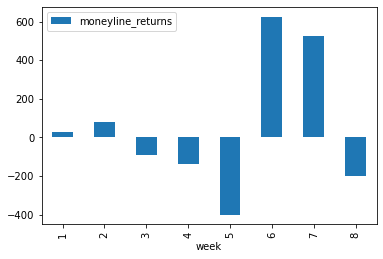

In [29]:
# Moneyline returns

gambling_df.groupby(by=['week']).sum()['moneyline_returns'].reset_index().plot.bar(x='week', y='moneyline_returns')

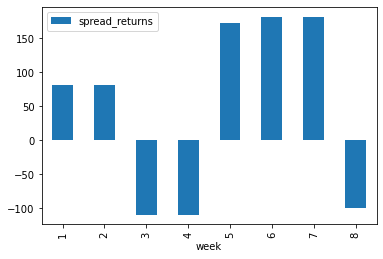

In [30]:
# Spread returns

gambling_df.groupby(by=['week']).sum()['spread_returns'].reset_index().plot.bar(x='week', y='spread_returns')

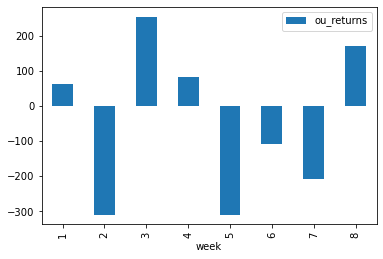

In [31]:
# O/U returns

gambling_df.groupby(by=['week']).sum()['ou_returns'].reset_index().plot.bar(x='week', y='ou_returns')

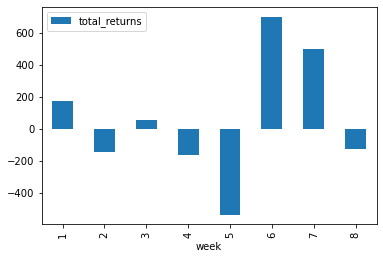

In [32]:
# Total Returns 

gambling_df.groupby(by=['week']).sum()['total_returns'].reset_index().plot.bar(x='week', y='total_returns')

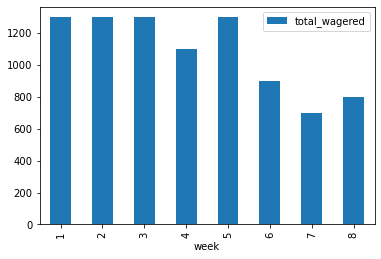

In [33]:
# Total Wagered

gambling_df.groupby(by=['week']).sum()['total_wagered'].reset_index().plot.bar(x='week', y='total_wagered')

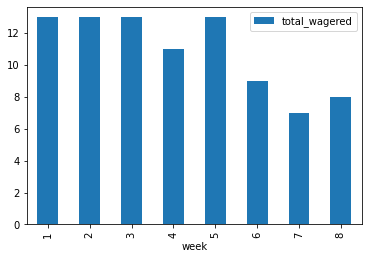

In [34]:
(gambling_df.groupby(by=['week']).sum()['total_wagered']/100).reset_index().plot.bar(x='week', y='total_wagered')

In [35]:
print('Moneyline Returns: {}'.format(gambling_df.sum().moneyline_returns))
print('Point Spread Returns: {}'.format(gambling_df.sum().spread_returns))
print('Over/Under Returns: {}'.format(gambling_df.sum().ou_returns))

print('Total Returns: {}'.format(gambling_df.sum().total_returns))

print('Total Wagered: {}'.format(gambling_df.sum().total_wagered))

print('Average Wagered: {}'.format(gambling_df.sum().total_wagered/4))

Moneyline Returns: 432.48
Point Spread Returns: 381.83
Over/Under Returns: -363.6200000000001
Total Returns: 450.6899999999996
Total Wagered: 8700.0
Average Wagered: 2175.0
